# MB_molec

In [580]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [581]:
import seaborn as sns
sns.set()

In [582]:
df = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/4way/mb_t1_t2_4way.xlsx")

In [583]:
reduced_features = pd.read_excel("/Users/michaelzhang/Desktop/peds_tumor/mbpyradiomics/molec_classifier/4way/4way_reduced.xlsx")

In [584]:
reduced_features_list = reduced_features.loc[reduced_features['coeff3'].isnull() == False, ['coeff3']].values.tolist()

In [585]:
reduced_features_list = [item for sublist in reduced_features_list for item in sublist]

In [586]:
reduced_features_list

['sex',
 't1_original_shape_Flatness',
 't1_wavelet-HLL_glcm_Correlation',
 't1_wavelet-LHL_glcm_Correlation',
 't2_wavelet-LLL_glcm_Autocorrelation',
 't2_wavelet-LHL_firstorder_Energy',
 't2_log-sigma-5-mm-3D_firstorder_TotalEnergy',
 't2_wavelet-HHL_glrlm_ShortRunHighGrayLevelEmphasis',
 't2_wavelet-HLL_firstorder_90Percentile',
 't2_log-sigma-5-mm-3D_firstorder_Energy',
 't2_log-sigma-5-mm-3D_firstorder_Maximum',
 't2_original_shape_Elongation']

In [587]:
target = df["molecular"]

In [588]:
target.value_counts()

shh      83
type4    64
type3    48
wnt      26
Name: molecular, dtype: int64

In [589]:
#Marking 0 as wnt and shh as pilo and 2 as other
mapping_dict = {0: 'wnt', 1: 'shh', 2: 'type3', 3: 'type4'} ##
target = target.map(dict(wnt = 0, shh = 1, type3 = 2, type4 = 3)) ##

In [590]:
target.value_counts()

1    83
3    64
2    48
0    26
Name: molecular, dtype: int64

In [591]:
features_after_lasso = df[reduced_features_list]

In [592]:
sex_binarized = features_after_lasso['sex'].map(dict(M = 1, F = 0)).to_numpy()

features_after_lasso['sex'] = sex_binarized

<ipython-input-592-d335f8c9da81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_after_lasso['sex'] = sex_binarized


In [593]:
features_after_lasso 

,sex,t1_original_shape_Flatness,t1_wavelet-HLL_glcm_Correlation,t1_wavelet-LHL_glcm_Correlation,t2_wavelet-LLL_glcm_Autocorrelation,t2_wavelet-LHL_firstorder_Energy,t2_log-sigma-5-mm-3D_firstorder_TotalEnergy,t2_wavelet-HHL_glrlm_ShortRunHighGrayLevelEmphasis,t2_wavelet-HLL_firstorder_90Percentile,t2_log-sigma-5-mm-3D_firstorder_Energy,t2_log-sigma-5-mm-3D_firstorder_Maximum,t2_original_shape_Elongation
0,0,0.682624,0.207668,0.164886,2593.640747,7.855152e+06,1.271189e+07,52.991344,19.094002,1.271189e+07,24.569717,0.885463
1,0,0.669803,0.099840,0.080252,897.957351,1.776711e+06,8.444865e+06,62.594548,19.556963,8.444865e+06,20.461651,0.636828
2,0,0.695603,0.175950,0.013351,2369.836116,2.753361e+07,5.267252e+07,61.568093,29.554031,5.267252e+07,35.118561,0.904310
3,0,0.840785,0.051403,0.165649,810.119189,1.583997e+06,1.174093e+07,8.119632,11.491369,1.174093e+07,7.092341,0.873919
4,0,0.591087,0.217793,0.198333,2276.612451,8.533643e+06,7.204847e+06,140.170845,29.905953,7.204847e+06,42.097076,0.749160
...,...,...,...,...,...,...,...,...,...,...,...,...
216,1,0.791002,0.303572,0.176035,2549.224000,3.199013e+07,2.895736e+07,54.357172,23.420190,2.895736e+07,31.788048,0.830650
217,1,0.710371,0.145812,0.030740,1176.476998,2.687953e+07,1.719192e+07,116.223138,25.327489,1.719192e+07,14.189934,0.800564
218,1,0.818867,0.288205,0.162970,1013.433391,1.110800e+07,1.595256e+07,148.043897,22.263073,1.595256e+07,11.414841,0.877963
219,1,0.848850,0.233316,0.119297,1776.191930,3.127807e+07,2.226132e+07,152.396319,23.042838,2.226132e+07,37.745102,0.879026


In [594]:
X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, 
                                                    test_size = 0.25, random_state = 42)

In [595]:
y_train.value_counts()

1    67
3    49
2    31
0    18
Name: molecular, dtype: int64

In [596]:
y_test.value_counts()

2    17
1    16
3    15
0     8
Name: molecular, dtype: int64

# Principal Components Analysis - [Removed]

# Resampling to correct for imbalance

In [597]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0]
X_1 = X[X['molecular'] == 1] ## shh is highest
X_2 = X[X['molecular'] == 2]
X_3 = X[X['molecular'] == 3] ##

In [598]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_1), random_state = 42)
upsampled_2 = resample(X_2, replace = True, n_samples = len(X_1), random_state = 42)
upsampled_3 = resample(X_3, replace = True, n_samples = len(X_1), random_state = 42) ## 2/shh with most N

upsampled = pd.concat([upsampled_0, upsampled_2, upsampled_3, X_1])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [599]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

In [600]:
y_train.value_counts()

3    67
2    67
1    67
0    67
Name: molecular, dtype: int64

In [601]:
y_train_bin = label_binarize(y_train, classes = [0, 1, 2, 3])
y_test_bin = label_binarize(y_test, classes = [0, 1, 2, 3])

# Standardizing Features

In [602]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [603]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [604]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

In [605]:
def specificity_score(y_pred, y_true):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [606]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [607]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [608]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.3f} - {:0.3}]".format(name, i,
        confidence_lower, confidence_upper))

In [609]:
def my_classification_report(y_test_np, y_pred):

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    spec_arr = []
    ppv_arr = [] ##
    npv_arr = [] ##
    rec_arr = []
    acc_arr = [] 

    print("Specificities")
    for group in range(4):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TN += TN
        tot_FP += FP
        spec_arr.append(TN/(TN+FP))
        print(group, spec_arr[group])

    print("Macro Avg : " + str(np.array(spec_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FP)), '\n') ##

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("PPV/Precision") ##
    for group in range(4):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
        tot_TP += TP
        tot_FP += FP
        ppv_arr.append(TP/(TP+FP))
        print(group, ppv_arr[group])
    
    print("Macro Avg : " + str(np.array(ppv_arr).mean()))
    prec_for_mic_f1 = tot_TP / (tot_TP + tot_FP)
    print("Micro Avg : " + str(prec_for_mic_f1), '\n')

    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("NPV") ##
    for group in range(4):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TN += TN
        tot_FN += FN
        npv_arr.append(TN/(TN+FN))
        print(group, npv_arr[group])
    
    print("Macro Avg : " + str(np.array(npv_arr).mean()))
    print("Micro Avg : " + str(tot_TN / (tot_TN + tot_FN)), '\n') 
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Recall") ##
    for group in range(4):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        tot_TP += TP
        tot_FN += FN
        rec_arr.append(TP/(TP+FN))
        print(group, rec_arr[group])
    
    print("Macro Avg : " + str(np.array(rec_arr).mean()))
    rec_for_mic_f1 = tot_TP / (tot_TP + tot_FN)
    print("Micro Avg : " + str(rec_for_mic_f1), '\n')
    
    print("F1 Score") ##
    for group in range(4):
        print(group, 2 * (rec_arr[group] * ppv_arr[group]) / (rec_arr[group] + ppv_arr[group]))
    print("Macro Avg : " + str(2 * (np.array(rec_arr).mean() * np.array(ppv_arr).mean()) 
                               / (np.array(rec_arr).mean() + np.array(ppv_arr).mean())))
    print("Micro Avg : " + str(2 * (prec_for_mic_f1 * rec_for_mic_f1)/ (prec_for_mic_f1 + rec_for_mic_f1)), '\n')
    
    tot_TN = 0
    tot_TP = 0
    tot_FP = 0
    tot_FN = 0

    print("Accuracy:")
    for group in range(4):
        TN = 0
        TP = 0 ##
        FN = 0 ##
        FP = 0
        for i in range(len(y_test_np)):
            if y_pred[i] == group and y_test_np[i] == group:
                TP += 1
            if y_pred[i] != group and y_test_np[i] != group:
                TN += 1
            if y_pred[i] == group and y_test_np[i] != group:
                FP += 1
            if y_pred[i] != group and y_test_np[i] == group:
                FN += 1
        
        tot_TP += TP
        tot_TN += TN
        tot_FP += FP
        tot_FN += FN
        
        acc_arr.append((TP + TN)/(TP + TN + FP + FN))
        print(group, acc_arr[group])
        #print("TP:" + str(TP))
        #print("TN:" + str(TN))
        #print("FP:" + str(FP))
        #print("FN:" + str(FN))
        
        #print(TP + TN)
        #print(TP + TN + FP + FN, '\n')
        
    #print("Total TP:" + str(tot_TP))
    #print("Total TN:" + str(tot_TN))
    #print("Total FP:" + str(tot_FP))
    #print("Total FN:" + str(tot_FN), '\n')

    print("Macro Avg : " + str(np.array(acc_arr).mean()))
    print("Micro Avg : " + str((tot_TP + tot_TN)/(tot_TP + tot_TN + tot_FP + tot_FN)), '\n') ##

# SVM

### Grid Search for Hyperparameters

In [610]:
svm_model = OneVsRestClassifier(svm.SVC())

In [611]:
grid_param = {'estimator__C': [0.1, 1, 10],
              'estimator__gamma': [1, 0.1, 0.01]
}


svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [612]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [613]:
print(svm_grid.best_params_)

{'estimator__C': 10, 'estimator__gamma': 1}


### Model Performance

In [614]:
svm_model = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [615]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8125
1 0.725
2 0.8205128205128205
3 0.8292682926829268
Macro Avg : 0.7968202782989369
Micro Avg : 0.7976190476190477 

PPV/Precision
0 0.35714285714285715
1 0.3888888888888889
2 0.46153846153846156
3 0.36363636363636365
Macro Avg : 0.39280164280164287
Micro Avg : 0.39285714285714285 

NPV
0 0.9285714285714286
1 0.7631578947368421
2 0.7441860465116279
3 0.7555555555555555
Macro Avg : 0.7978677313438636
Micro Avg : 0.7976190476190477 

Recall
0 0.625
1 0.4375
2 0.35294117647058826
3 0.26666666666666666
Macro Avg : 0.42052696078431373
Micro Avg : 0.39285714285714285 

F1 Score
0 0.45454545454545453
1 0.411764705882353
2 0.4000000000000001
3 0.30769230769230765
Macro Avg : 0.40619174171464645
Micro Avg : 0.39285714285714285 

Accuracy:
0 0.7857142857142857
1 0.6428571428571429
2 0.6785714285714286
3 0.6785714285714286
Macro Avg : 0.6964285714285714
Micro Avg : 0.6964285714285714 



In [616]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.62      0.45         8
           1       0.39      0.44      0.41        16
           2       0.46      0.35      0.40        17
           3       0.36      0.27      0.31        15

    accuracy                           0.39        56
   macro avg       0.39      0.42      0.39        56
weighted avg       0.40      0.39      0.39        56



In [617]:
n_classes = 4 ##
svm_model_for_auc = OneVsRestClassifier(svm.SVC(C = 10, gamma = 0.01, probability = True))
y_score = svm_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = svm_model_for_auc.predict(X_test)

wnt
Accuracy: 0.7857142857142857
shh
Accuracy: 0.6964285714285714
type3
Accuracy: 0.6607142857142857
type4
Accuracy: 0.7142857142857143
Micro-Averaged AUC: 0.6721938775510203


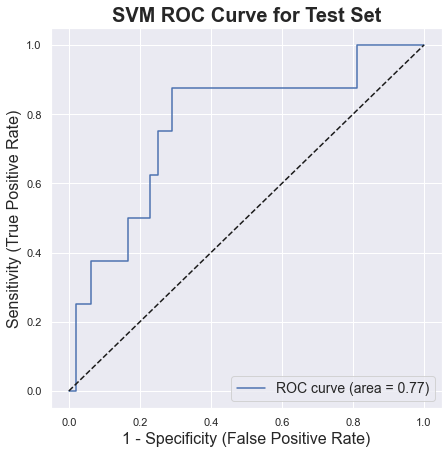

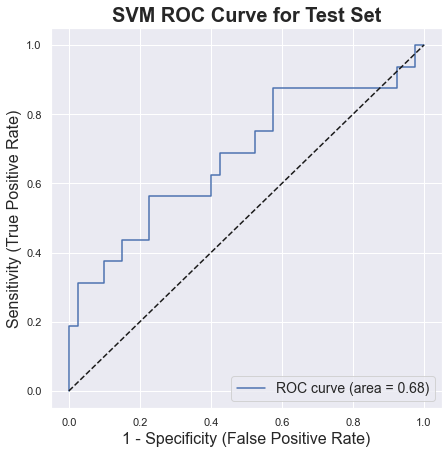

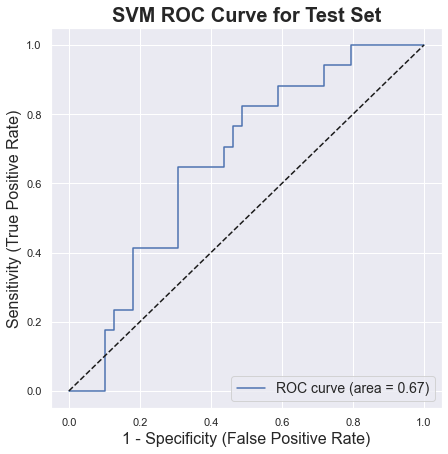

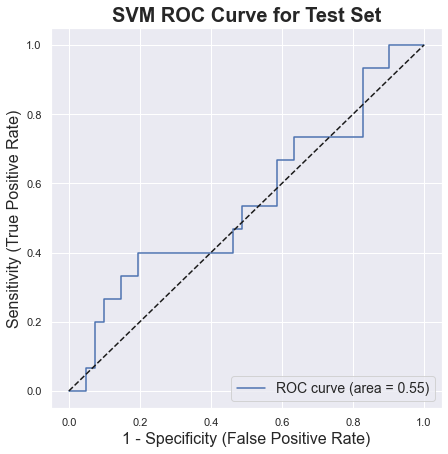

In [618]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))



# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('SVM ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()


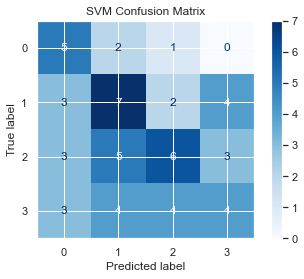

In [619]:
matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

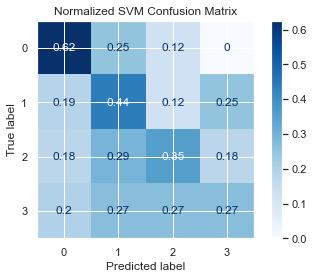

In [620]:
norm_matrix = plot_confusion_matrix(svm_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [621]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##

    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [622]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

# Logistic Regression

### Grid Search for Hyperparameters

In [623]:
lr_model = OneVsRestClassifier(LogisticRegression())
grid_param = {'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'estimator__C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [624]:
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10, 1, 0.1, 0.01, 0.001],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                'none']},
             scoring='accuracy')

In [625]:
print(lr_grid.best_params_)

{'estimator__C': 1, 'estimator__penalty': 'l2'}


### Model Performance

In [626]:
lr_model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1))
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [627]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8541666666666666
1 0.75
2 0.8205128205128205
3 0.7804878048780488
Macro Avg : 0.801291823014384
Micro Avg : 0.8035714285714286 

PPV/Precision
0 0.36363636363636365
1 0.4444444444444444
2 0.46153846153846156
3 0.35714285714285715
Macro Avg : 0.4066905316905317
Micro Avg : 0.4107142857142857 

NPV
0 0.9111111111111111
1 0.7894736842105263
2 0.7441860465116279
3 0.7619047619047619
Macro Avg : 0.8016689009345068
Micro Avg : 0.8035714285714286 

Recall
0 0.5
1 0.5
2 0.35294117647058826
3 0.3333333333333333
Macro Avg : 0.4215686274509804
Micro Avg : 0.4107142857142857 

F1 Score
0 0.4210526315789474
1 0.47058823529411764
2 0.4000000000000001
3 0.3448275862068965
Macro Avg : 0.4139959512667319
Micro Avg : 0.4107142857142857 

Accuracy:
0 0.8035714285714286
1 0.6785714285714286
2 0.6785714285714286
3 0.6607142857142857
Macro Avg : 0.7053571428571428
Micro Avg : 0.7053571428571429 



In [628]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.50      0.42         8
           1       0.44      0.50      0.47        16
           2       0.46      0.35      0.40        17
           3       0.36      0.33      0.34        15

    accuracy                           0.41        56
   macro avg       0.41      0.42      0.41        56
weighted avg       0.41      0.41      0.41        56



In [629]:
n_classes = 4
lr_model_for_auc = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 1, random_state = 42))
y_score = lr_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = lr_model_for_auc.predict(X_test)

wnt
Accuracy: 0.8392857142857143
shh
Accuracy: 0.7142857142857143
type3
Accuracy: 0.6607142857142857
type4
Accuracy: 0.7142857142857143
Micro-Averaged ROC: 0.6957908163265305


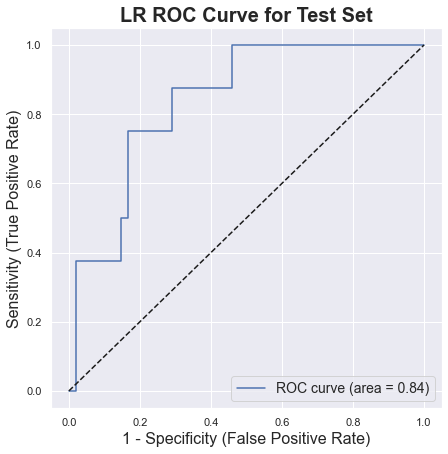

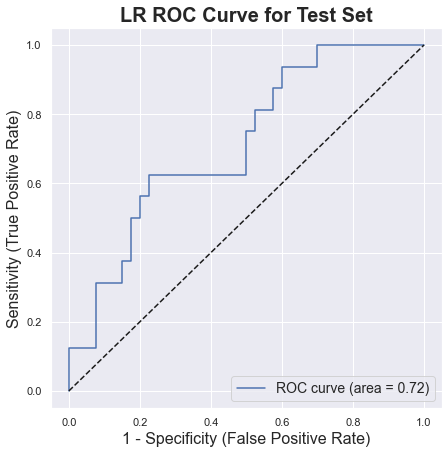

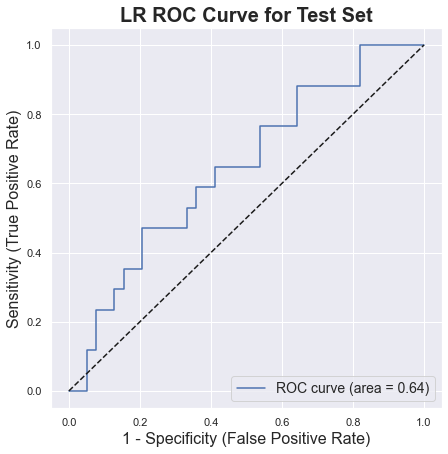

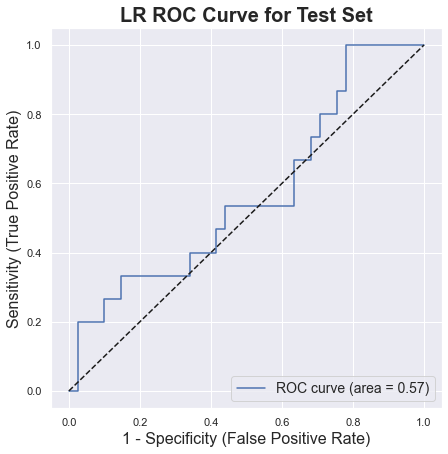

In [630]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged ROC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('LR ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

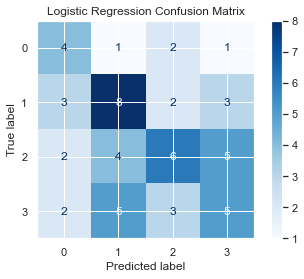

In [631]:
matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

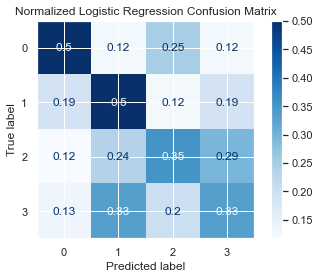

In [632]:
norm_matrix = plot_confusion_matrix(lr_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [633]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [634]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

Feature: 0, Score: -0.62092
Feature: 1, Score: -0.59078
Feature: 2, Score: -0.23620
Feature: 3, Score: -1.09700
Feature: 4, Score: -0.73989
Feature: 5, Score: -0.18557
Feature: 6, Score: 0.37543
Feature: 7, Score: 0.34945
Feature: 8, Score: 1.31396
Feature: 9, Score: 0.37543
Feature: 10, Score: -0.18920
Feature: 11, Score: -0.66128


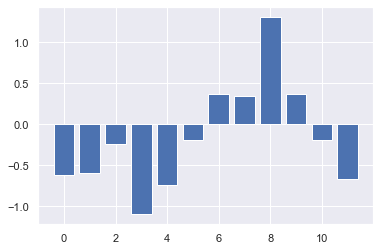

In [635]:
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

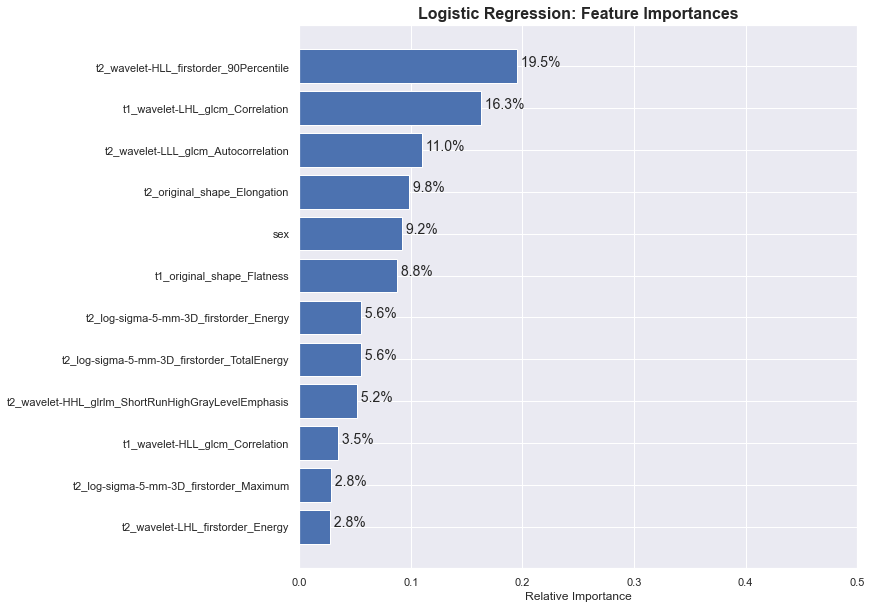

In [636]:
feature_names = X_test.columns.to_list()
importance = lr_model.coef_[0]
importance = np.abs(importance) / np.sum(np.abs(importance))
indices = np.argsort(importance)

plt.figure(figsize=(10, 10)) ##
plt.title('Logistic Regression: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.xlim(0, 0.50) ##
for index, value in enumerate(importance[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

# KNN

### Grid Search for Hyperparameters

In [637]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [638]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='accuracy')

In [639]:
print(knn_grid.best_params_)

{'n_neighbors': 3}


### Model Performance

In [640]:
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [641]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8958333333333334
1 0.775
2 0.6923076923076923
3 0.8780487804878049
Macro Avg : 0.8102974515322077
Micro Avg : 0.8154761904761905 

PPV/Precision
0 0.2857142857142857
1 0.5
2 0.4
3 0.5454545454545454
Macro Avg : 0.4327922077922078
Micro Avg : 0.44642857142857145 

NPV
0 0.8775510204081632
1 0.8157894736842105
2 0.75
3 0.8
Macro Avg : 0.8108351235230935
Micro Avg : 0.8154761904761905 

Recall
0 0.25
1 0.5625
2 0.47058823529411764
3 0.4
Macro Avg : 0.4207720588235294
Micro Avg : 0.44642857142857145 

F1 Score
0 0.26666666666666666
1 0.5294117647058824
2 0.4324324324324324
3 0.4615384615384615
Macro Avg : 0.42669749762964243
Micro Avg : 0.44642857142857145 

Accuracy:
0 0.8035714285714286
1 0.7142857142857143
2 0.625
3 0.75
Macro Avg : 0.7232142857142857
Micro Avg : 0.7232142857142857 



In [642]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.29      0.25      0.27         8
           1       0.50      0.56      0.53        16
           2       0.40      0.47      0.43        17
           3       0.55      0.40      0.46        15

    accuracy                           0.45        56
   macro avg       0.43      0.42      0.42        56
weighted avg       0.45      0.45      0.44        56



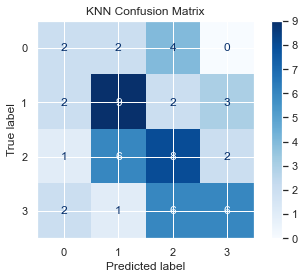

In [643]:
matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

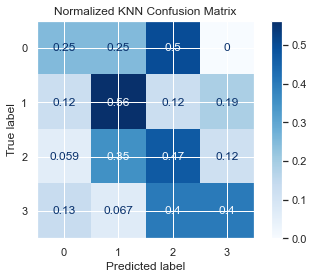

In [644]:
norm_matrix = plot_confusion_matrix(knn_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized KNN Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8035714285714286
shh
Accuracy: 0.7142857142857143
type3
Accuracy: 0.625
type4
Accuracy: 0.75
Micro-Averaged AUC: 0.668579931972789


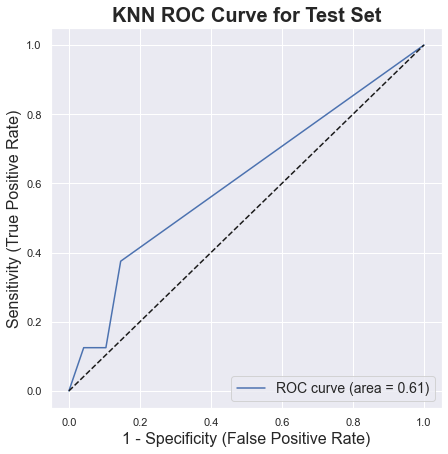

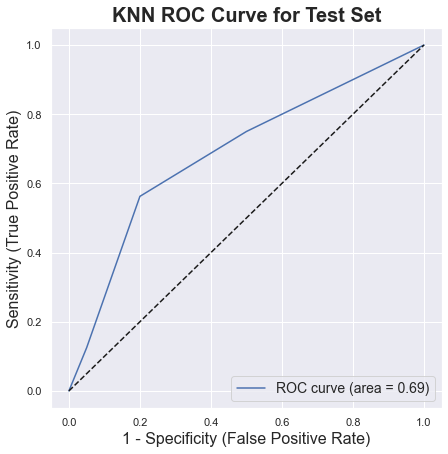

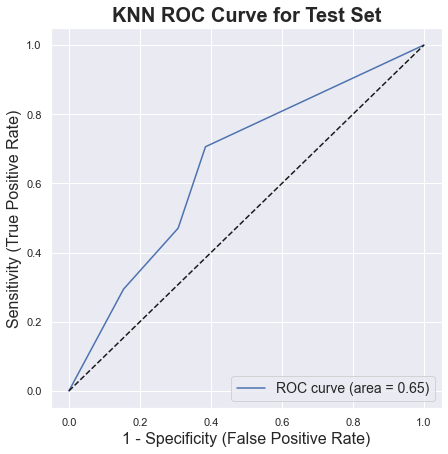

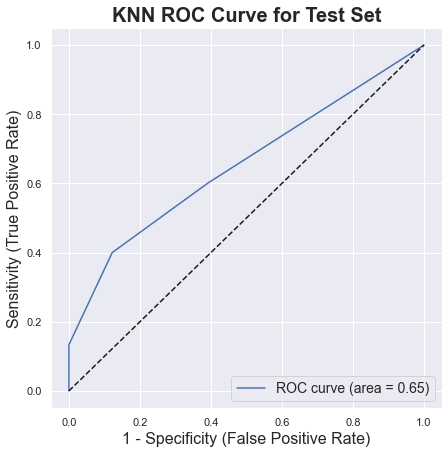

In [645]:
y_score = knn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3])##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('KNN ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [646]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [647]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

# Random Forest

### Grid Search for Hyperparameters
 

In [648]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [649]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [None, 50, 100, 200, 300]},
             scoring='accuracy')

In [650]:
print(rf_grid.best_params_)

{'max_depth': 4, 'n_estimators': 100}


### Model Performance

In [683]:
rf_model = RandomForestClassifier(max_depth = 4, n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [684]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.25      0.24         8
           1       0.44      0.69      0.54        16
           2       0.44      0.24      0.31        17
           3       0.46      0.40      0.43        15

    accuracy                           0.41        56
   macro avg       0.39      0.39      0.38        56
weighted avg       0.42      0.41      0.40        56



In [685]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.8541666666666666
1 0.65
2 0.8717948717948718
3 0.8292682926829268
Macro Avg : 0.8013074577861163
Micro Avg : 0.8035714285714286 

PPV/Precision
0 0.2222222222222222
1 0.44
2 0.4444444444444444
3 0.46153846153846156
Macro Avg : 0.39205128205128204
Micro Avg : 0.4107142857142857 

NPV
0 0.8723404255319149
1 0.8387096774193549
2 0.723404255319149
3 0.7906976744186046
Macro Avg : 0.8062880081722559
Micro Avg : 0.8035714285714286 

Recall
0 0.25
1 0.6875
2 0.23529411764705882
3 0.4
Macro Avg : 0.3931985294117647
Micro Avg : 0.4107142857142857 

F1 Score
0 0.23529411764705882
1 0.5365853658536586
2 0.30769230769230765
3 0.42857142857142855
Macro Avg : 0.3926240676692361
Micro Avg : 0.4107142857142857 

Accuracy:
0 0.7678571428571429
1 0.6607142857142857
2 0.6785714285714286
3 0.7142857142857143
Macro Avg : 0.7053571428571429
Micro Avg : 0.7053571428571429 



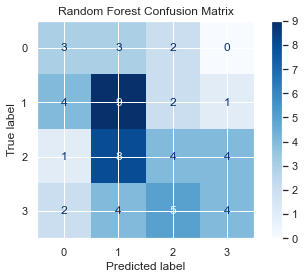

In [654]:
matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

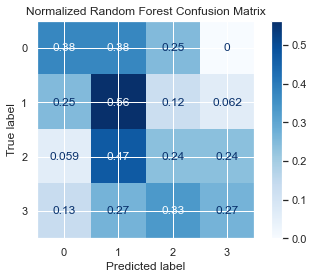

In [655]:
norm_matrix = plot_confusion_matrix(rf_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.7857142857142857
shh
Accuracy: 0.6071428571428571
type3
Accuracy: 0.6071428571428571
type4
Accuracy: 0.7142857142857143
Micro-Averaged AUC: 0.6806972789115646


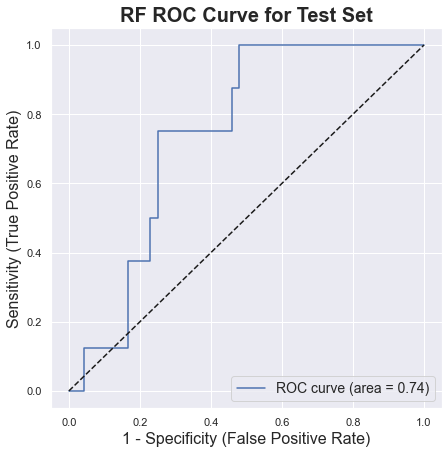

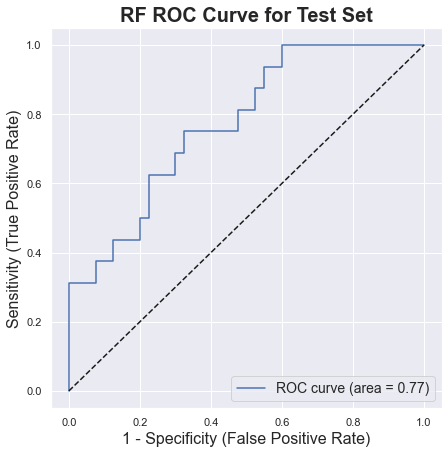

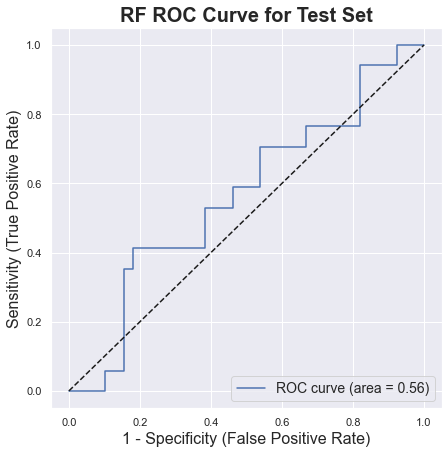

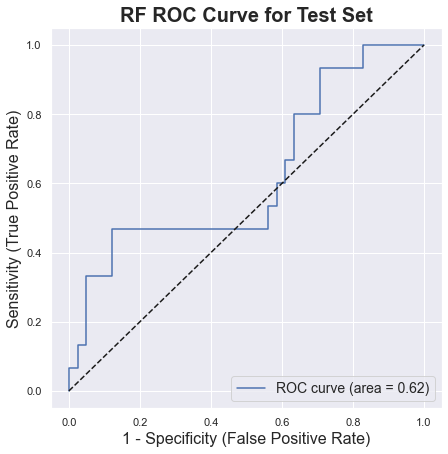

In [656]:
y_score = rf_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('RF ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [657]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [658]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

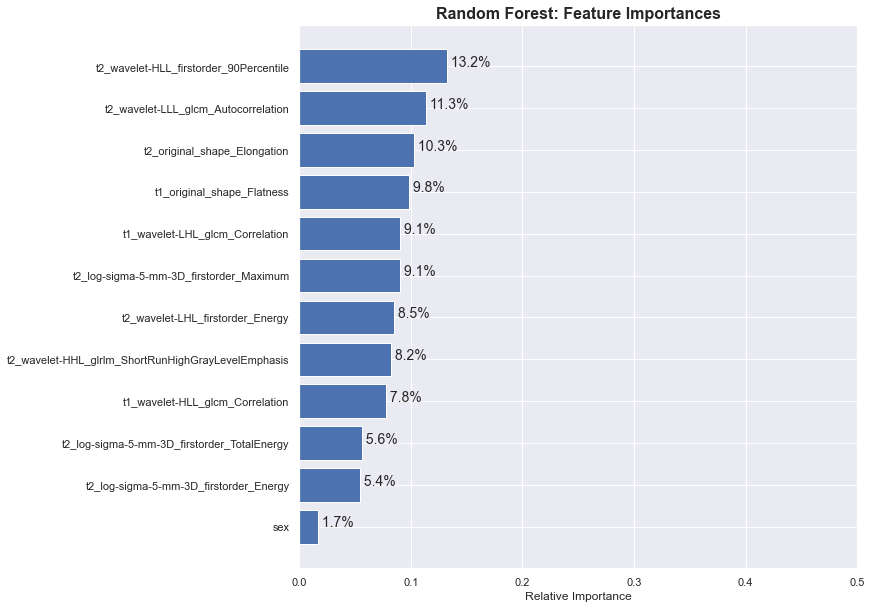

In [659]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10)) ##
plt.title('Random Forest: Feature Importances', fontsize=16, fontweight='semibold') ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.50) ##
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# XGBoost

### Grid Search for Hyperparameters

In [660]:
xgb_model = XGBClassifier(objective = 'multi:softmax', random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [661]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsampl

In [662]:
print(xgb_grid.best_params_)

{'learning_rate': 0.5, 'max_depth': 4}


### Model Performance

In [686]:
xgb_model = XGBClassifier(objective = 'multi:softmax', learning_rate = 0.5, max_depth = 4, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [687]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.9166666666666666
1 0.45
2 0.8717948717948718
3 0.8780487804878049
Macro Avg : 0.7791275797373358
Micro Avg : 0.7857142857142857 

PPV/Precision
0 0.2
1 0.3333333333333333
2 0.375
3 0.5
Macro Avg : 0.3520833333333333
Micro Avg : 0.35714285714285715 

NPV
0 0.8627450980392157
1 0.782608695652174
2 0.7083333333333334
3 0.782608695652174
Macro Avg : 0.7840739556692242
Micro Avg : 0.7857142857142857 

Recall
0 0.125
1 0.6875
2 0.17647058823529413
3 0.3333333333333333
Macro Avg : 0.33057598039215685
Micro Avg : 0.35714285714285715 

F1 Score
0 0.15384615384615385
1 0.4489795918367347
2 0.24
3 0.4
Macro Avg : 0.340990859587709
Micro Avg : 0.35714285714285715 

Accuracy:
0 0.8035714285714286
1 0.5178571428571429
2 0.6607142857142857
3 0.7321428571428571
Macro Avg : 0.6785714285714286
Micro Avg : 0.6785714285714286 



In [665]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         8
           1       0.34      0.69      0.46        16
           2       0.25      0.12      0.16        17
           3       0.50      0.33      0.40        15

    accuracy                           0.36        56
   macro avg       0.36      0.35      0.33        56
weighted avg       0.36      0.36      0.33        56



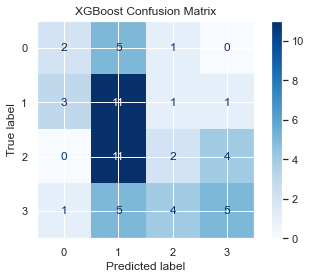

In [666]:
matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

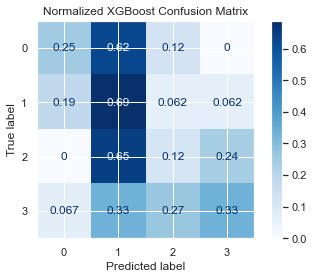

In [667]:
norm_matrix = plot_confusion_matrix(xgb_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8214285714285714
shh
Accuracy: 0.5357142857142857
type3
Accuracy: 0.625
type4
Accuracy: 0.7321428571428571
Micro-Averaged AUC: 0.6274447278911565


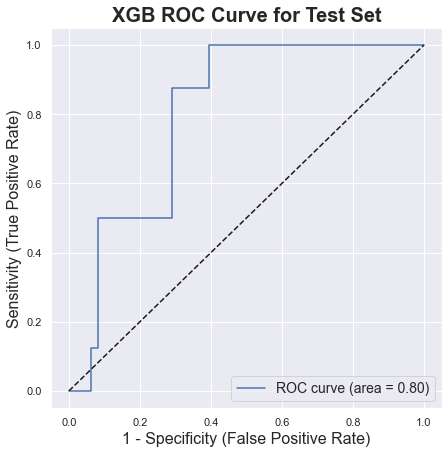

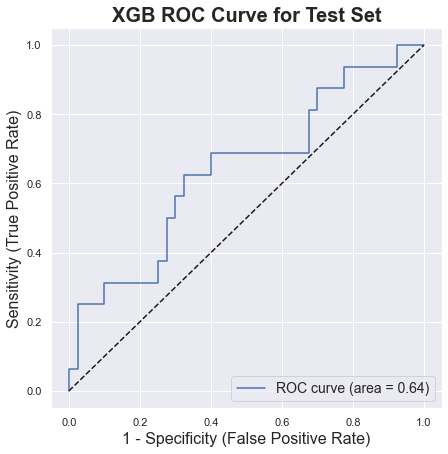

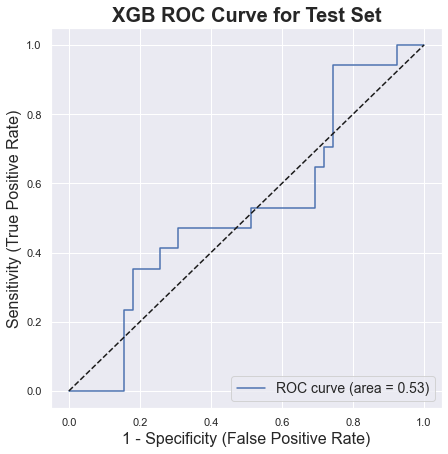

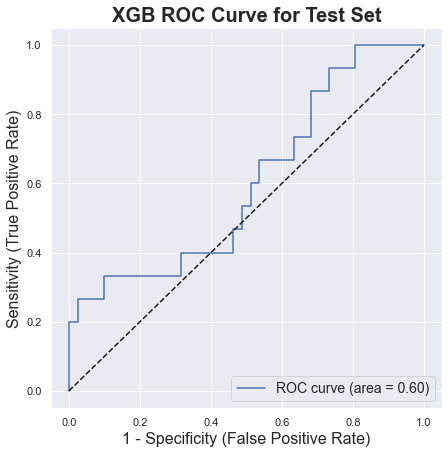

In [668]:
y_score = xgb_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('XGB ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [669]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/Users/michaelzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [670]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##

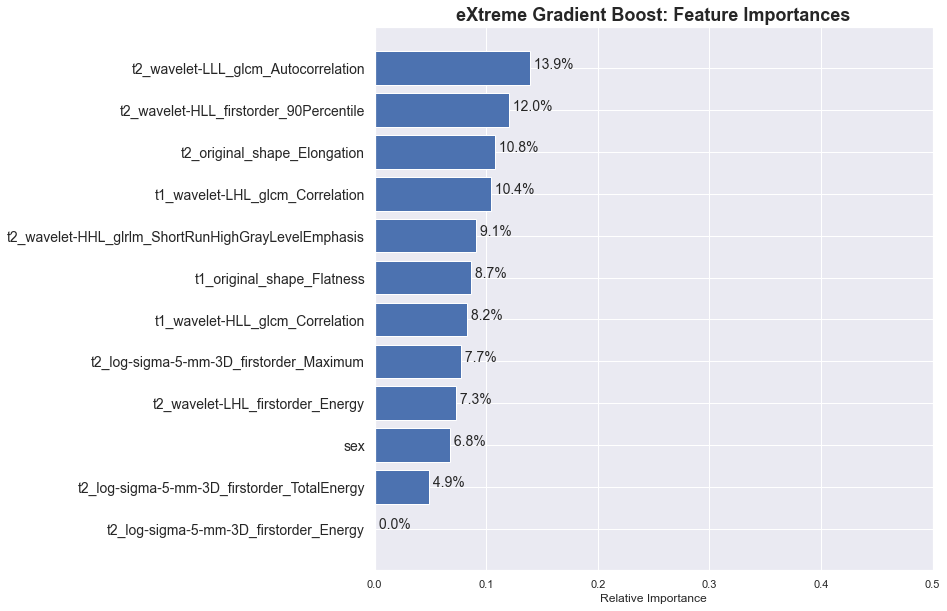

In [671]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10)) ##
plt.title('eXtreme Gradient Boost: Feature Importances', fontsize=18, fontweight='semibold') ##
plt.xlim(0, 0.50) ##
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
for index, value in enumerate(importances[indices]): ##
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance')

plt.show()

# Neural Net

### Grid Search for Hyperparameters

In [672]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [673]:
nn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50),
                                                (100, 50, 100)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive']},
             scoring='accuracy')

In [674]:
print(nn_grid.best_params_)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


### Model Performance

In [688]:
nn_model = MLPClassifier(hidden_layer_sizes = (100, 100, 50), learning_rate = 'constant', 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [689]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Specificities
0 0.875
1 0.5
2 0.8717948717948718
3 0.926829268292683
Macro Avg : 0.7934060350218887
Micro Avg : 0.7976190476190477 

PPV/Precision
0 0.25
1 0.3548387096774194
2 0.4444444444444444
3 0.625
Macro Avg : 0.4185707885304659
Micro Avg : 0.39285714285714285 

NPV
0 0.875
1 0.8
2 0.723404255319149
3 0.7916666666666666
Macro Avg : 0.7975177304964539
Micro Avg : 0.7976190476190477 

Recall
0 0.25
1 0.6875
2 0.23529411764705882
3 0.3333333333333333
Macro Avg : 0.37653186274509803
Micro Avg : 0.39285714285714285 

F1 Score
0 0.25
1 0.4680851063829787
2 0.30769230769230765
3 0.43478260869565216
Macro Avg : 0.39643997776442724
Micro Avg : 0.39285714285714285 

Accuracy:
0 0.7857142857142857
1 0.5535714285714286
2 0.6785714285714286
3 0.7678571428571429
Macro Avg : 0.6964285714285715
Micro Avg : 0.6964285714285714 



In [677]:
print(classification_report(y_test, y_pred))
##not a direct classifier

              precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.43      0.62      0.51        16
           2       0.46      0.35      0.40        17
           3       0.42      0.33      0.37        15

    accuracy                           0.43        56
   macro avg       0.42      0.42      0.41        56
weighted avg       0.43      0.43      0.42        56



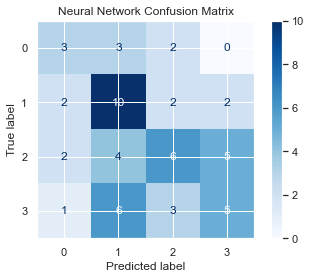

In [678]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

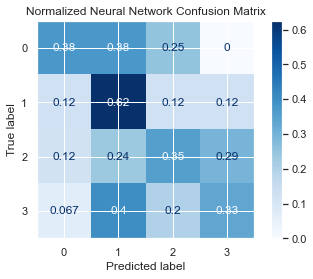

In [679]:
matrix = plot_confusion_matrix(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8214285714285714
shh
Accuracy: 0.6607142857142857
type3
Accuracy: 0.6785714285714286
type4
Accuracy: 0.6964285714285714
Micro-Averaged AUC: 0.6592261904761905


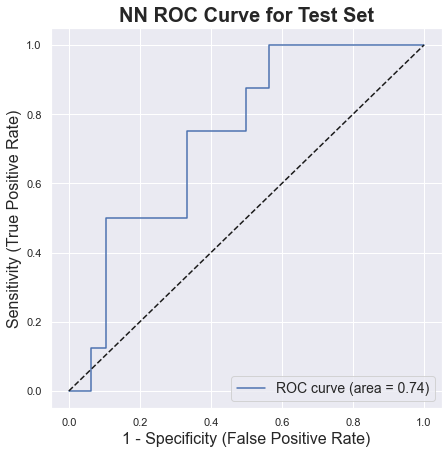

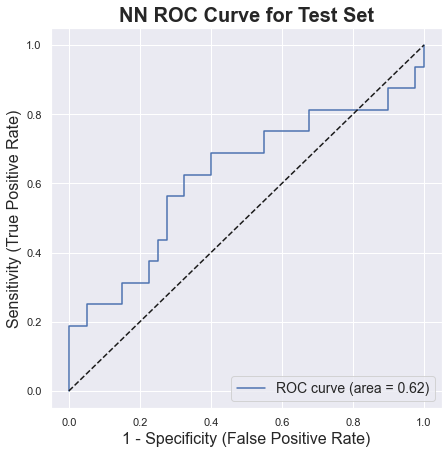

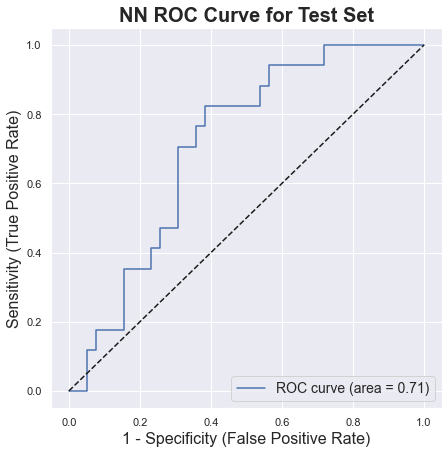

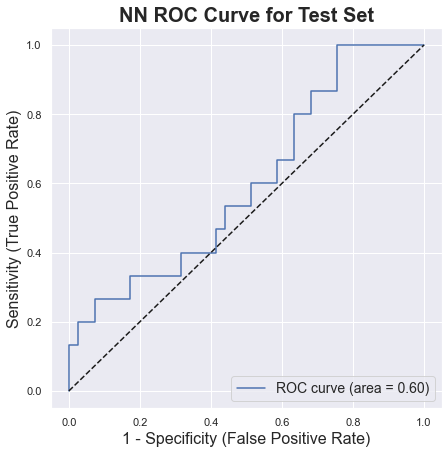

In [680]:
y_score = nn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('NN ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

In [681]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] 
bootstrapped_npv_scores = [] 

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices])) ##
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

In [682]:
#create_ci(bootstrapped_auc_scores, "AUC")
#create_ci(bootstrapped_acc_scores, "Accuracy")
#create_ci(bootstrapped_spec_scores, "Specificity")
#create_ci(bootstrapped_prec_scores, "Precision")
#create_ci(bootstrapped_rec_scores, "Recall")
#create_ci(bootstrapped_f_one_scores, "F1")
#create_ci(bootstrapped_ppv_scores, "PPV") ##
#create_ci(bootstrapped_npv_scores, "NPV") ##